In [1]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import optuna

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   o

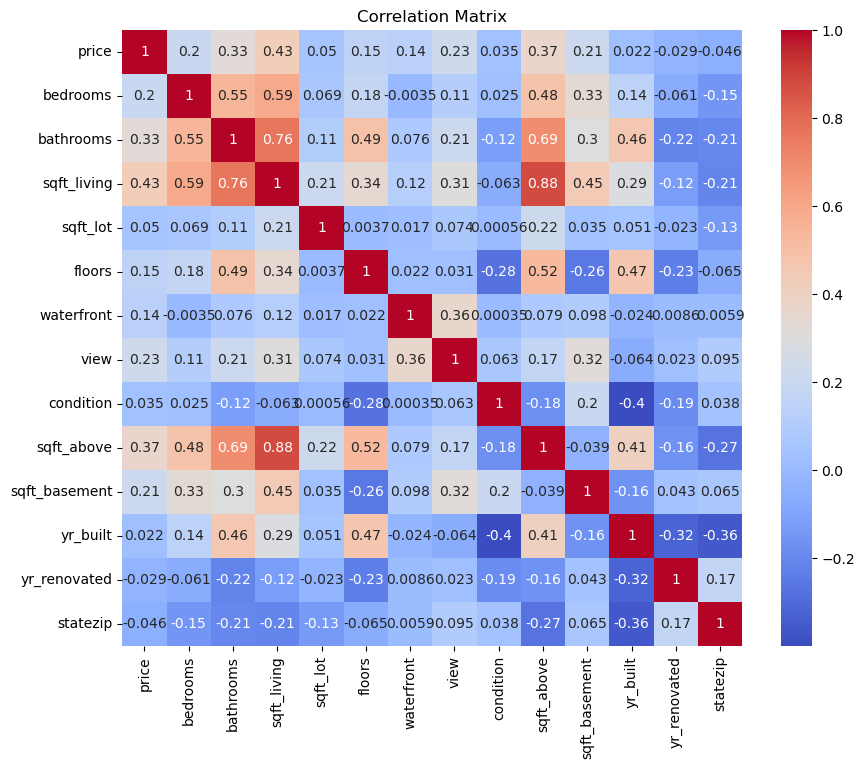

Outliers removed


In [2]:
# Load the dataset
print("Loading the dataset")
data_path = 'data.csv'  
df = pd.read_csv(data_path)

# check
print(df.info())
print("Data loaded successfully\n")

# Handle missing values
df.dropna(inplace=True) 
print("Missing values handled")

# Convert statezip to an integer
df["statezip"] = df["statezip"].apply(lambda x: int(x.split(" ")[1]))
print("statezip converted to an integer")

# Drop non-numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

# Display the correlation matrix
print("\nDisplaying correlation matrix")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Remove outliers based on the IQR method
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
df_numeric = df_numeric[
    ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
]
print("Outliers removed")

In [3]:
# Re-integrate non-numeric columns after outlier removal
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

# Feature Engineering: Add polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out()

df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)
print("Advanced feature engineering applied")

# Define features and target
features = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "floors",
    "statezip",
    "waterfront",
    "view",
    "sqft_above",
    "sqft_basement",
    "yr_renovated",
] + list(poly_feature_names)
X = df[features]
y = df["price"]
print("Features and target defined")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and test sets")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

Non-numeric columns re-integrated after outlier removal
Advanced feature engineering applied
Features and target defined
Data split into training and test sets
Features scaled


In [4]:
# Train model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Model trained & predictions made")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

# Extract the feature importances
feature_importances = model.feature_importances_

# Select top features
threshold = 0.25
important_features = X.columns[feature_importances > threshold]
X_train_trimmed = X_train[important_features]
X_test_trimmed = X_test[important_features]

# Retrain model with trimmed features
model.fit(X_train_trimmed, y_train)
y_pred_trimmed = model.predict(X_test_trimmed)
print("\nTrimmed model trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


Model trained & predictions made
Cross-Validation Scores: [0.27783835 0.3929375  0.38949479 0.27489538 0.40023809]
Mean CV Score: 0.35

Trimmed model trained & predictions made
Cross-Validation Scores: [0.47746763 0.51288856 0.52536997 0.62174283 0.54320829]
Mean CV Score: 0.54


In [5]:
# # Gradient Boosting 
# model = GradientBoostingRegressor(n_estimators=895, learning_rate=0.04, max_depth=3, random_state=42)

# # Retrain model
# model.fit(X_train_trimmed, y_train)
# y_pred_gb = model.predict(X_train_trimmed)
# print("Gradient Boosting model trained & predictions made")

# cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
# print(f'Cross-Validation Scores: {cv_scores}')
# print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


In [6]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [10, 12, 14, 16],
    'min_samples_split': [0.95, 2, 3],
    'min_samples_leaf': [0.9, 0.95, 1],
}

# Perform grid search with range of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_trimmed, y_train)
print("Best Parameters:", grid_search.best_params_)

# Retrain model
best_params = grid_search.best_params_
model = DecisionTreeRegressor(random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (GridSearchCV) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

# Hyperparameter tuning using Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
    }
    
    model = DecisionTreeRegressor(random_state=42, **param)
    model.fit(X_train_trimmed, y_train)
    y_pred = model.predict(X_test_trimmed)
    r2 = r2_score(y_test, y_pred)
    return r2

# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Parameters:", study.best_params)


# Retrain model
best_params = study.best_params
model = DecisionTreeRegressor(random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (with Optuna) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

[I 2024-05-24 10:58:18,509] A new study created in memory with name: no-name-98ae9fed-fa90-405c-8f4b-b8f952985d8a
[I 2024-05-24 10:58:18,513] Trial 0 finished with value: 0.3222534581658051 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3222534581658051.
[I 2024-05-24 10:58:18,518] Trial 1 finished with value: 0.4988933014169 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 1 with value: 0.4988933014169.
[I 2024-05-24 10:58:18,522] Trial 2 finished with value: 0.5090733795077835 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.5090733795077835.
[I 2024-05-24 10:58:18,527] Trial 3 finished with value: 0.43289382860895487 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 2 with v

Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuned model (GridSearchCV) trained & predictions made
Cross-Validation Scores: [0.47746763 0.51288856 0.52552171 0.62174283 0.54320829]
Mean CV Score: 0.54


[I 2024-05-24 10:58:18,709] Trial 17 finished with value: 0.5091162050112101 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 17 with value: 0.5091162050112101.
[I 2024-05-24 10:58:18,726] Trial 18 finished with value: 0.5050522182103505 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 17 with value: 0.5091162050112101.
[I 2024-05-24 10:58:18,745] Trial 19 finished with value: 0.5052507999906813 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.5091162050112101.


Best Parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}

Tuned model (with Optuna) trained & predictions made
Cross-Validation Scores: [0.47675558 0.51083148 0.52499203 0.62174213 0.54548037]
Mean CV Score: 0.54


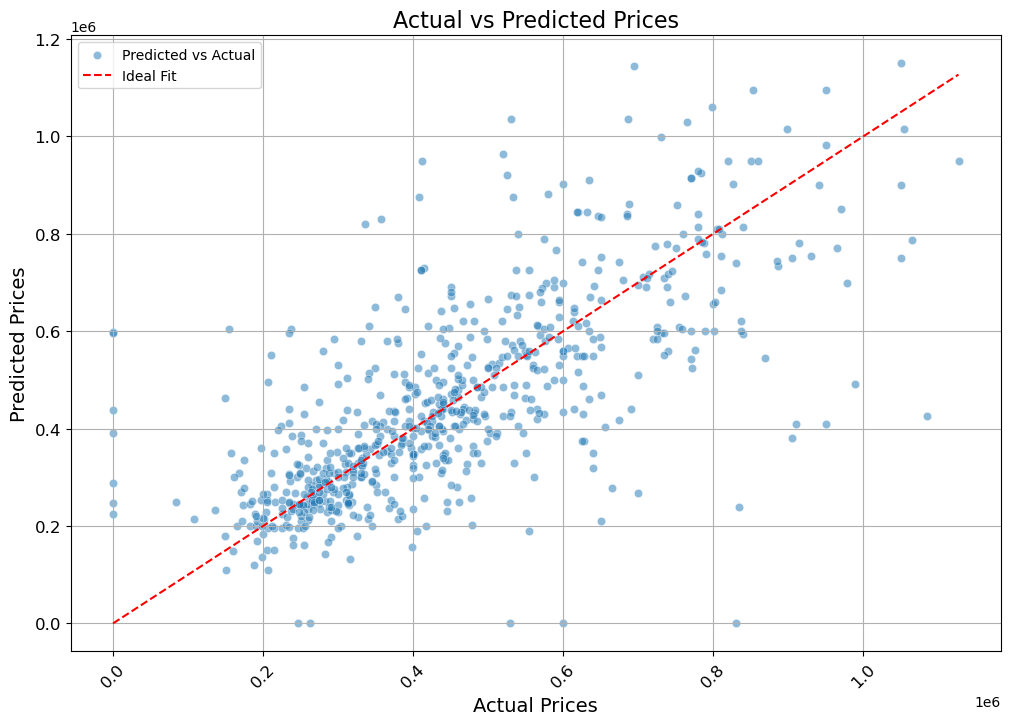

Mean Squared Error: 19520216535.95
R-squared: 0.51

Cross-Validation Scores: [0.47675558 0.51083148 0.52499203 0.62174213 0.54548037]
Mean CV Score: 0.54


In [7]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_final)
r_squared = r2_score(y_test, y_pred_final)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Cross-Validation
cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')